In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%load_ext autoreload

%autoreload 2

%matplotlib notebook
sns.set()

In [2]:
from mdetsims import Sim

In [56]:
mbobs = Sim(
    rng=np.random.RandomState(seed=38957),
    g1=0.02,
    gal_type='ground_galsim_parametric',
    psf_type='gauss',
    n_coadd=4).get_mbobs()

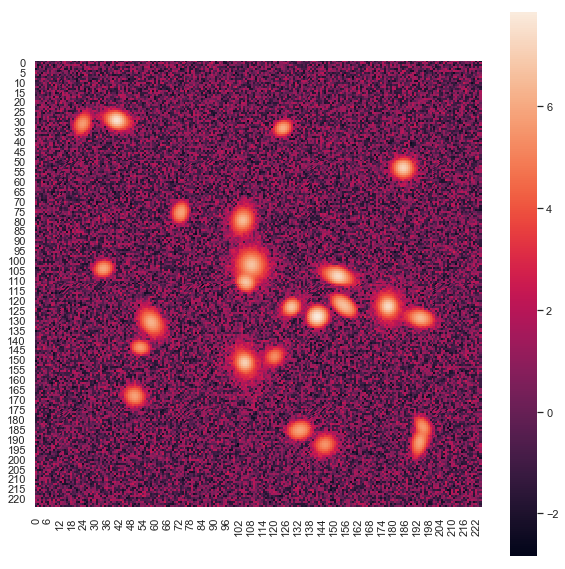

In [57]:
plt.figure(figsize=(10, 10))
sns.heatmap(np.arcsinh(mbobs[0][0].image), square=True)